# Time-Based Algorithm: blind SQL injection vulnerability detection

In this notebook, I consider the problem of blind SQL injection vulnerability detection using a custom time-based algorithm. Specifically, making mutiple requests (half with a high sleep delay and the other half with a low sleep delay) to the url being tested and comparing their RTTs to decide whether the url is vulnerable (label 1) or safe (label 0)

**Optimization:** The goal is optimize the algorithm for speed and accuracy. More speficically, it needs to have a true positive rate of less than 0.0001 (1 in 10,000) and a sleep delay that returns a RTT of less than 10 seconds on average

Import libraries

In [31]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import csv
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline

# Part (a): Data Exploration

1. Collect RTTS of safe and vulnerable URLs and save them into CSV files.

2. Compare the safe and vulnerable RTTs by visualizing them and comparing their mean (as well as other metrics).


**1. Collect RTTS of vulnerable and safe urls**

In [54]:
def collect_rtts(page_type = 'safe', n_pages = 100, sleep_delay = 0):
    '''
    Collects RTTS from URLs and saves them into CSV file
    '''
    
    if sleep_delay != 0:
        query = 'SLEEP({})'.format(sleep_delay)
        file_name = '{}_{}_{}.csv'.format(page_type, n_page, sleep_delay)
    
    else:
        query = '1'
        file_name = '{}_{}.csv'.format(page_type, n_pages)
    
    with open(file_name, 'w') as file:
        writer = csv.writer(file, delimiter=',', lineterminator='\n')
        writer.writerow(['URL', 'RTT'])
        for i in range(1, n_pages+1):
            url = 'http://localhost:5000/{}/{}/page?id={}'.format(page_type, page_num, query)
            response = requests.get(url)
            row = [url, response.elapsed.total_seconds()]
            writer.writerow(row)

In [55]:
# Read data
safe_df = pd.read_csv('Data/safe_100.csv')
vul_df = pd.read_csv('Data/vulnerable_100.csv')
vul_delay_df = pd.read_csv('Data/vulnerable_100_1.csv') # 1 second sleep delay injected

In [37]:
safe_df.head()

,URL,RTT
0,http://localhost:5000/safe/1/page?id=1,6.554458
1,http://localhost:5000/safe/2/page?id=1,3.299523
2,http://localhost:5000/safe/3/page?id=1,2.255223
3,http://localhost:5000/safe/4/page?id=1,2.725735
4,http://localhost:5000/safe/5/page?id=1,4.646487


**2. Compare the RTTs and try to find a trend.**

Text(0, 0.5, 'ECDF')

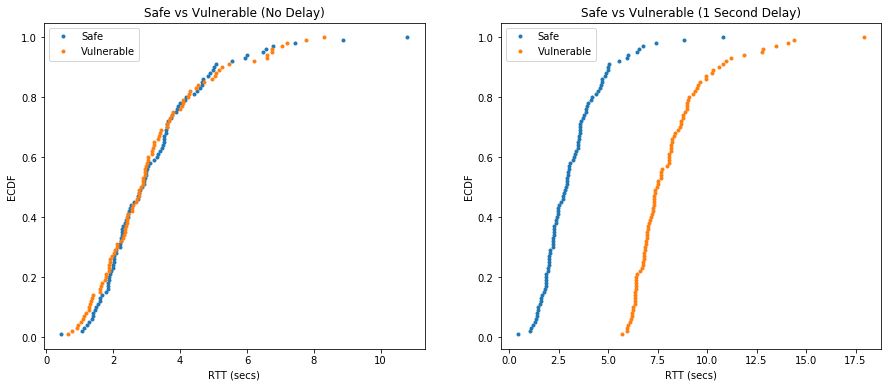

In [36]:
# Calculating CDFs
safe_ecdf = ECDF(safe_df['RTT'])
vul_ecdf = ECDF(vul_df['RTT'])
vul_delay_ecdf = ECDF(vul_delay_df['RTT']) 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#fig.tight_layout()

ax[0].plot(safe_ecdf.x, safe_ecdf.y, marker='.', linestyle='none')
ax[0].plot(vul_ecdf.x, vul_ecdf.y, marker='.', linestyle='none')

ax[1].plot(safe_ecdf.x, safe_ecdf.y, marker='.', linestyle='none')
ax[1].plot(vul_delay_ecdf.x, vul_ecdf.y, marker='.', linestyle='none')

ax[0].set_title('Safe vs Vulnerable (No Delay)')
ax[0].legend(('Safe', 'Vulnerable'), loc='best')
ax[0].set_xlabel('RTT (secs)')
ax[0].set_ylabel('ECDF')

ax[1].set_title('Safe vs Vulnerable (1 Second Delay)')
ax[1].legend(('Safe', 'Vulnerable'), loc='best')
ax[1].set_xlabel('RTT (secs)')
ax[1].set_ylabel('ECDF')

In [58]:
print('The mean of the safe URL without a sleep injection is: {}'.format(np.mean(safe_df['RTT'])))

The mean of the safe URL without a sleep injection is: 3.1995424299999997


In [59]:
print('The mean of the vulnerable URL with 1 second sleep injection: {}'.format(np.mean(vul_delay_df['RTT'])))

The mean of the vulnerable URL with 1 second sleep injection: 8.141448309999998


**Observation:** As suspected, without a sleep delay injected, both safe and vulnerable urls have a similar distribution of RTTs. On the other hand, adding a sleep delay of 1 second to the vulnerables urls incresease their delays by about 5 seconds.

## Part (b): Time-based Algorithm

1. 

In [ ]:
async def get_url_rtt(url, session, i):
    '''
    Collects the request RTT of the "url" passed above and returns it along with and id "i"
    '''

    get_url_rtt.start_time[url+str(i)] = timeit.default_timer()
    async with session.get(url) as response:
        resp = await response.read()
        rtt = timeit.default_timer() - get_url_rtt.start_time[url+str(i)]
        return (i, rtt)

def analyze_rtts(rtts, diff):
    '''
    Analyses two sets of rtts and decides whether the difference shows a vulnerability or not
    Using dummy way of analyzing the rtts. will be replaced with more sophisticated method
    '''

    low_delay = []
    high_delay = []
    for rtt in rtts:
        if rtt[0] % 2 == 0:
            high_delay.append(rtt[1])
        else:
            low_delay.append(rtt[1])
    
    difference = np.median(high_delay) - np.median(low_delay)

    # If the the high and low rtts differ by more than 
    return int(difference >= diff)

## Part (c) Evaluating Results

In [62]:
safe_test_df = pd.read_csv('Data/safe_results_10500_0.8_0.03_24_3.csv')
vul_test_df = pd.read_csv('Data/vulnerable_results_10500_0.8_0.03_24_3.csv')

In [63]:
safe_test_df.head()

,Test Result
0,0
1,0
2,0
3,0
4,0


In [70]:
# Get False Positive Rate (FPR)
fpr = float(np.sum(safe_test_df['Test Result'])/safe_test_df.shape[0])
print('The False Positive Rate is: {}'.format(fpr))


# Get False Negative Rate (FNR)
fnr = float(vul_test_df[vul_test_df['Test Result'] == 0].count()/vul_test_df.shape[0])
print('The False Negative Rate is: {}'.format(fnr))

The False Positive Rate is: 0.0
The False Negative Rate is: 0.09342857142857143
